# **Pneumonia Recognition Application using CNNs**
The following code implements a Convolutional Neural Network (CNN) for pneumonia detection in chest X-ray images based on Resnet architecture.

# Dataset
The model is trained on a dataset of chest X-ray images with corresponding labels. The dataset contains 5,863 x-rays images (JPEG) divided into two categories (pneumonia / normal). The dataset contains 3 subsets: train, value, test. Chest X-ray images were selected from retrospective cohorts of pediatric patients of 1 to 5 years old from Guangzhou Women and Children’s Medical Center, Guangzhou.

# Model Architecture
The model's architecture is based on the classic **ResNet**, adapted for the specific task of medical image analysis. It utilizes convolutional layers to extract features from the input images, followed by pooling layers to reduce dimensionality, and fully connected layers to classify the images as either 'pneumonia' or 'normal'.

# Results
Performance evaluation is measured by the accuracy and loss and presented in the learning rate curves visualisation.

In [ ]:
#Importing libraries
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses, Model
import kagglehub
import os
import glob
import pandas as pd
import numpy as np
import cv2
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
'''This code snippet downloads the pneumonia dataset, locates
    the training and testing images within it, and stores the
    paths to these images in separate lists for later use in
    the application.'''

#Loading image data
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
main_path = os.path.join(path , "chest_xray")

train_path = os.path.join(main_path,"train")
test_path=os.path.join(main_path,"test")

train_normal = glob.glob(train_path+"/NORMAL/*.jpeg")
train_pneumonia = glob.glob(train_path+"/PNEUMONIA/*.jpeg")

test_normal = glob.glob(test_path+"/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_path+"/PNEUMONIA/*.jpeg")


In [ ]:
#Creating separate datasets
train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), columns = ['class'])
df_train['image'] = [x for x in train_list]

test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
df_test['image'] = [x for x in test_list]
print(df_test)



         class                                              image
0       Normal  C:\Users\OMAR BUSAILEH\.cache\kagglehub\datase...
1       Normal  C:\Users\OMAR BUSAILEH\.cache\kagglehub\datase...
2       Normal  C:\Users\OMAR BUSAILEH\.cache\kagglehub\datase...
3       Normal  C:\Users\OMAR BUSAILEH\.cache\kagglehub\datase...
4       Normal  C:\Users\OMAR BUSAILEH\.cache\kagglehub\datase...
..         ...                                                ...
619  Pneumonia  C:\Users\OMAR BUSAILEH\.cache\kagglehub\datase...
620  Pneumonia  C:\Users\OMAR BUSAILEH\.cache\kagglehub\datase...
621  Pneumonia  C:\Users\OMAR BUSAILEH\.cache\kagglehub\datase...
622  Pneumonia  C:\Users\OMAR BUSAILEH\.cache\kagglehub\datase...
623  Pneumonia  C:\Users\OMAR BUSAILEH\.cache\kagglehub\datase...

[624 rows x 2 columns]


In [ ]:
#Splitting training dataset into train and validation subsets
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df_train, test_size = 0.20, random_state = 42, stratify = df_train['class'])

In [ ]:

#Data pre-processing via ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 224  #images will be resized to 224x224 pixels
BATCH = 32      #the model will process 32 images at a time during training
SEED = 42       #random seed (42) for reproducibility

#Configuring to perform data augmentation on the training data
train_datagen = ImageDataGenerator(rescale=1/255.,
                                  zoom_range = 0.1,
                                  #rotation_range = 0.1,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1)

val_datagen = ImageDataGenerator(rescale=1/255.)

ds_train = train_datagen.flow_from_dataframe(train_df,
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             class_mode = 'binary',
                                             batch_size = BATCH,
                                             seed = SEED)

ds_val = val_datagen.flow_from_dataframe(val_df,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = BATCH,
                                            seed = SEED)

ds_test = val_datagen.flow_from_dataframe(df_test,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = 1,
                                            shuffle = False)

Found 4172 validated image filenames belonging to 2 classes.
Found 1044 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


Text(0.5, 1.0, 'Normal')

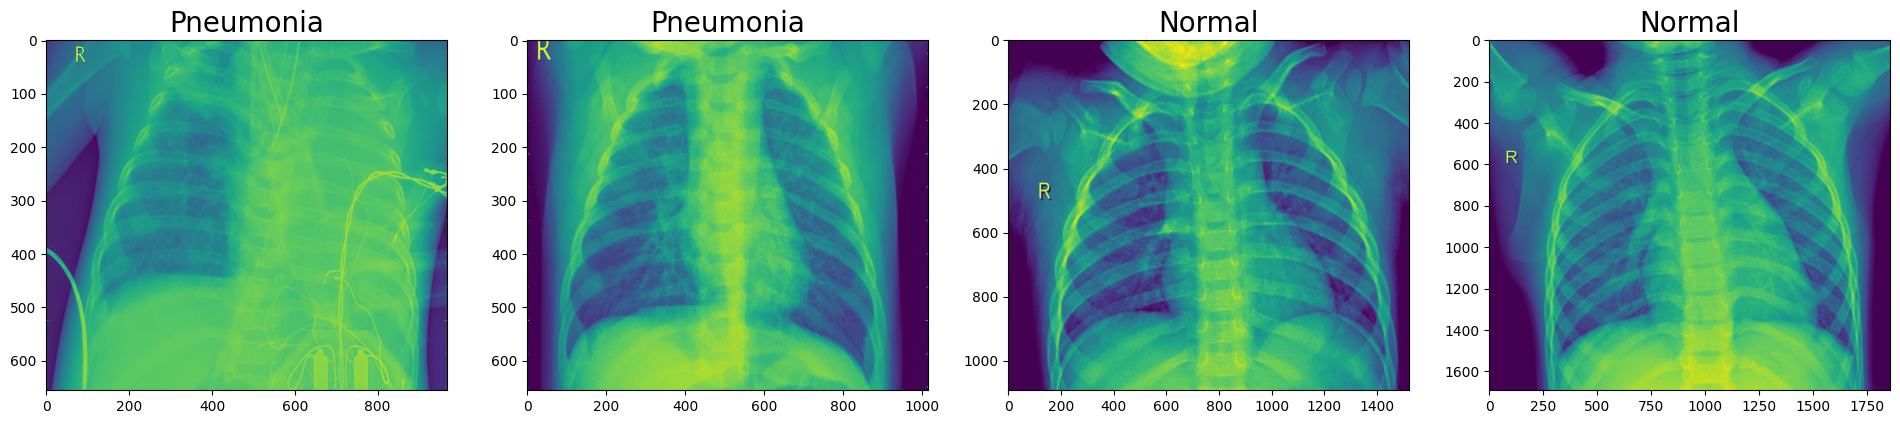

In [ ]:
#Visuals of images
pneumonia_df = train_df[train_df['class'] == 'Pneumonia']['image'].iloc[:10].tolist()
normal_df = train_df[train_df['class'] == 'Normal']['image'].iloc[:10].tolist()

fig = plt.figure(figsize = (30, 10))
plt.subplot(2,5,1)
image = cv2.imread(str(pneumonia_df[1]),cv2.COLOR_GRAY2BGR)
plt.imshow(image, aspect="auto")
plt.title('Pneumonia', fontsize = 20)

plt.subplot(2,5,2)
image = cv2.imread(str(pneumonia_df[2]),cv2.COLOR_GRAY2BGR)
plt.imshow(image, aspect="auto")
plt.title('Pneumonia', fontsize = 20)

plt.subplot(2,5,3)
image = cv2.imread(str(normal_df[0]),cv2.COLOR_GRAY2BGR)
plt.imshow(image, aspect="auto")
plt.title('Normal', fontsize = 20)

plt.subplot(2,5,4)
image = cv2.imread(str(normal_df[1]),cv2.COLOR_GRAY2BGR)
plt.imshow(image, aspect="auto")
plt.title('Normal', fontsize = 20)

In [ ]:
#Importing ResNet model and weights from 'ImageNet', top layers are ignored
base_model = tf.keras.applications.ResNet152V2(weights = 'imagenet', include_top = False, input_shape = (IMG_SIZE,IMG_SIZE,3))
base_model.trainable = False

In [ ]:
#A function to combine all model layers
def get_pretrained():
      """
    Creates a pre-trained model for image classification.

    This function defines a sequential model based on a pre-trained ResNet15V2 model.
    The top layers of the model are customized for a binary classification task.

    Returns:
        keras.Model: The compiled model ready for training or inference.
    """

    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    x = base_model(inputs)

    # Top Layers
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)

    #Output Layer
    output = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs=[inputs], outputs=output)

    return model

In [ ]:
#Compile the model
tf.keras.backend.clear_session()
model_pretrained = get_pretrained()
model_pretrained.compile(loss='binary_crossentropy'
              , optimizer = keras.optimizers.Adam(learning_rate=5e-5), metrics='binary_accuracy')

model_pretrained.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet152v2 (Functional)    (None, 7, 7, 2048)        58331648  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                             

In [ ]:
# Create an EarlyStopping callback to prevent overfitting
early_stop = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

In [ ]:
#Model Training
history = model_pretrained.fit(ds_train,
          batch_size = BATCH, epochs = 50,
          validation_data=ds_val,
          steps_per_epoch=(len(train_df)/BATCH),
          callbacks=[early_stop],
          validation_steps=(len(val_df)/BATCH))

Epoch 1/50
130/130 [==============================] - 49s 328ms/step - loss: 0.3719 - binary_accuracy: 0.8411 - val_loss: 0.1972 - val_binary_accuracy: 0.9291
Epoch 2/50
130/130 [==============================] - 42s 321ms/step - loss: 0.1995 - binary_accuracy: 0.9262 - val_loss: 0.1485 - val_binary_accuracy: 0.9397
Epoch 3/50
130/130 [==============================] - 42s 322ms/step - loss: 0.1672 - binary_accuracy: 0.9370 - val_loss: 0.1324 - val_binary_accuracy: 0.9473
Epoch 4/50
130/130 [==============================] - 42s 319ms/step - loss: 0.1492 - binary_accuracy: 0.9463 - val_loss: 0.1233 - val_binary_accuracy: 0.9521
Epoch 5/50
130/130 [==============================] - 42s 319ms/step - loss: 0.1310 - binary_accuracy: 0.9530 - val_loss: 0.1102 - val_binary_accuracy: 0.9617
Epoch 6/50
130/130 [==============================] - 42s 324ms/step - loss: 0.1293 - binary_accuracy: 0.9525 - val_loss: 0.0978 - val_binary_accuracy: 0.9655
Epoch 7/50
130/130 [==========================

In [ ]:
#Measuring model perofrmance on the test dataset
test_loss, test_accuracy = model_pretrained.evaluate(ds_train)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss * 100:.2f}%")

131/131 [==============================] - 38s 286ms/step - loss: 0.0693 - binary_accuracy: 0.9758
Test Accuracy: 97.58%
Test Loss: 6.93%


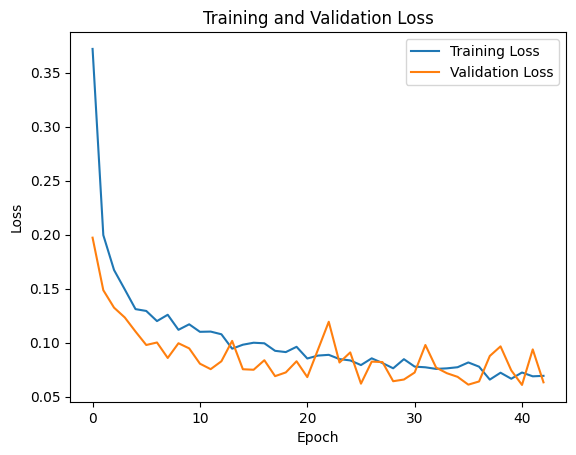

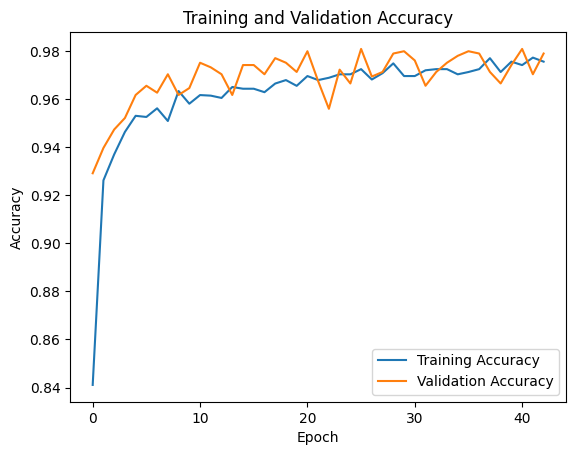

In [ ]:
#Learning rate curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Visualize the training and validation accuracy
plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()